In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import re
import warnings 
warnings.filterwarnings('ignore')
from subprocess import check_output

In [ ]:
print(check_output(["ls"]).decode("utf8"))
data = pd.read_csv('Reviews.csv')
data.columns

Reviews.csv
sample_data



Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
data = data[['Text','Score']]

In [ ]:
data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
row_select_1 = data['Score'] < 3
row_select_2 = data['Score'] == 3
data['sentiment'] = pd.Series(['Positive']*len(data.index))
data.loc[row_select_1,'sentiment'] = 'Negative'
data.loc[row_select_2,'sentiment'] = 'Neutral'

In [ ]:
data = data[['Text','sentiment']]
data.columns = ['text', 'sentiment']

In [ ]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

In [ ]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: str(x).lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen = maxlen)

12546
2448


In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5997, 100) (5997, 2)
(1500, 100) (1500, 2)


In [ ]:
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(16))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1136      
_________________________________________________________________
dense_3 (Dense)              (None, 2) 

In [ ]:
print('Train...')
cnn_lstmhist=model.fit(X_train, Y_train, batch_size=batch_size, epochs=4,shuffle=True, validation_data=(X_test, Y_test))

Train...
Epoch 1/4
200/200 [==============================] - 16s 82ms/step - loss: 0.3818 - accuracy: 0.8469 - val_loss: 0.3063 - val_accuracy: 0.8773
Epoch 2/4
200/200 [==============================] - 20s 101ms/step - loss: 0.1712 - accuracy: 0.9360 - val_loss: 0.2599 - val_accuracy: 0.8947
Epoch 3/4
200/200 [==============================] - 16s 82ms/step - loss: 0.0583 - accuracy: 0.9803 - val_loss: 0.3196 - val_accuracy: 0.8833
Epoch 4/4
200/200 [==============================] - 16s 82ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.4432 - val_accuracy: 0.8920


In [ ]:
yhat = model.predict(X_test, verbose = 2, batch_size = batch_size)
from sklearn import metrics
print(metrics.classification_report(Y_test[:,1], np.round(yhat[:,1]) ,target_names = ["negative", "positive"]))

50/50 - 0s
              precision    recall  f1-score   support

    negative       0.75      0.54      0.63       253
    positive       0.91      0.96      0.94      1247

    accuracy                           0.89      1500
   macro avg       0.83      0.75      0.78      1500
weighted avg       0.88      0.89      0.88      1500



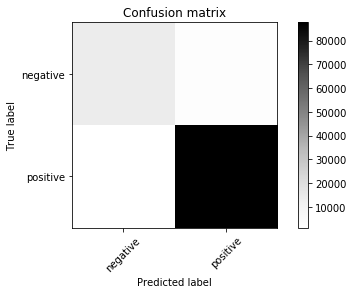

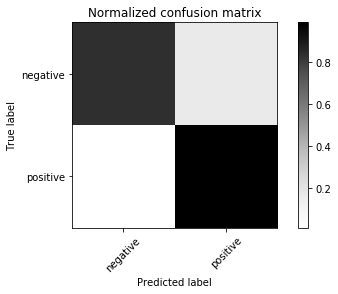

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

score = ['negative', 'positive']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_conv_lstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_conv_lstm.h5")